In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [50]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [51]:
hourly_nighlty_threshold = 10

# Random Forest Regresion Analysis Of Solar and Weather



In [52]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"
file_training_data = f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather"
file_testing_data = f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather"


__Load Test and Training Data_


In [53]:
df_daytime_train = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather")
df_daytime_test = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather")

# use list comprehension to get list of columns for level 1 and level 2 from weather data
# level 1 and levl 2 are based on condition codes from meteostat - it onehot encoding of weather conditions , with level 1 lowest level , and level 2 a summary level
level1_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level2_')]

In [54]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_daytime_train.columns, "Data Types": df_daytime_train.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
DayOfYear_Sin,DayOfYear_Sin,float64
HourOfDay_Sin,HourOfDay_Sin,float64
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64


## Histogram of various solar measures 

This shows a histogram of the various measures solar output. 

In [55]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="01"
test_name="All Features Level 1"
notes="All the features except level2_ features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
feature_cols.append('TOA')
feature_cols.append('Clear sky GHI')
feature_cols.append('Clear sky BHI')
feature_cols.append('Clear sky DHI')
feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
feature_cols.append('Power_ClearSky_Pane_I(W)')
feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
#  level2_features
#feature_cols += level2_features
#  level1_features
feature_cols += level1_features
#target_col = 'PV(W)'
target_col = 'Clearsky_Index'
print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")

print("Training DataFrame shape:", df_daytime_train.shape)
print("Testing DataFrame shape:", df_daytime_test.shape)
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]



Testing Random Forest Regressor with target: Clearsky_Index and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'Wind Cooling', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm']
Training DataFrame shape: (2358, 64)
Testing DataFrame shape: (2373, 64)


In [70]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=16,min_samples_split=5,min_samples_leaf=2)
# Train the model
print("Fitting model...")
rf_model.fit(X_train, y_train)
# Make predictions
print("Making predictions on test set...")
y_test_pred = rf_model.predict(X_test)
print("Making predictions on test set... Done")
# making predictions on training set
print("Making predictions on training set...")
y_train_pred = rf_model.predict(X_train)
print("Making predictions on training set... Done")
if target_col == 'PV(W)':
    print("Evaluating model for PV(W)...")
    # Evaluate the model
    y_train_pred_pvw = y_train_pred
    y_test_pred_pvw = y_test_pred
    y_train_pvw = y_train
    y_test_pvw = y_test
if target_col == 'Clearsky_Index':
    print("Evaluating model for Clearsky_Index...")
    # Evaluate the model
    y_train_pred_ci = y_train_pred
    y_test_pred_ci = y_test_pred
    y_train_pred_pvw = y_train_pred * df_daytime_train['Total_Power_ClearSky_Output(W)']
    y_test_pred_pvw = y_test_pred * df_daytime_test['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train * df_daytime_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test * df_daytime_test['Total_Power_ClearSky_Output(W)']

Fitting model...
Making predictions on test set...
Making predictions on test set... Done
Making predictions on training set...
Making predictions on training set... Done
Evaluating model for Clearsky_Index...


__Metrics for Tests 

### Random Forest Regressor Performance Metrics
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 0.01              | 0.03              |
| MAE          | 0.01              | 0.03              |
| R2           | 0.9213              | 0.5078              |
| N-RMSE (%)   | 5.0049              | 10.0335              |
| N-MAE (%)    | 3.4813              | 7.3712              |
| Accuracy (%) | 88.6896              | 73.0778              |

<Axes: xlabel='Importance', ylabel='Feature'>

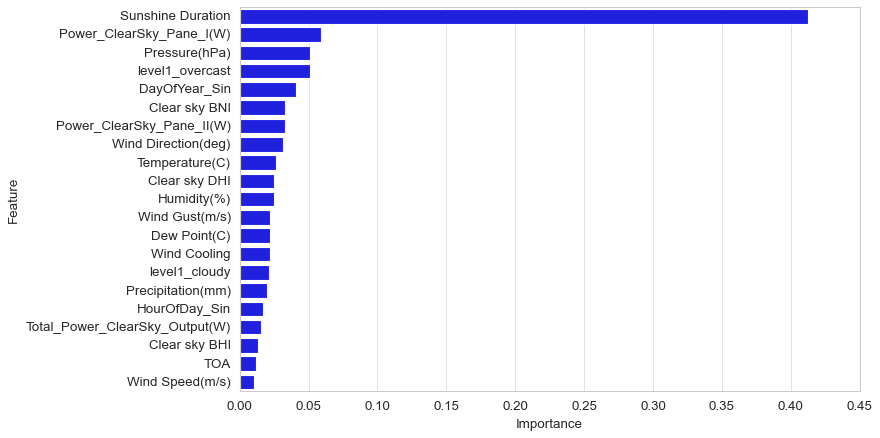

In [57]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
# # do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    normalization_factor = np.max(y_true) 
    #normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    # calculate accuracy as 1 - (mae / mean of y_true)
    accuracy_score = 1 - (mae / np.mean(y_true))
    return rmse, mae, r2 , n_rmse, n_mae, accuracy_score
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy = calculate_metrics(y_test, y_test_pred)
# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracy
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100
)
from IPython.display import display, Markdown
display(Markdown("### Random Forest Regressor Performance Metrics\n" + mk_string))
#print(f"\nTraining Metrics:\nRMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R2: {train_r2:.4f}, N-RMSE: {train_n_rmse:.4f}, N-MAE: {train_n_mae:.4f}, Accuracy: {train_accuracy:.4f}")
#print(f"\nTesting Metrics:\nRMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R2: {test_r2:.4f}, N-RMSE: {test_n_rmse:.4f}, N-MAE: {test_n_mae:.4f}, Accuracy: {test_accuracy:.4f}")
# feature importance plot
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# filter out all features with importance less than 0.01
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] >= 0.01]
# plot feature importance using seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)



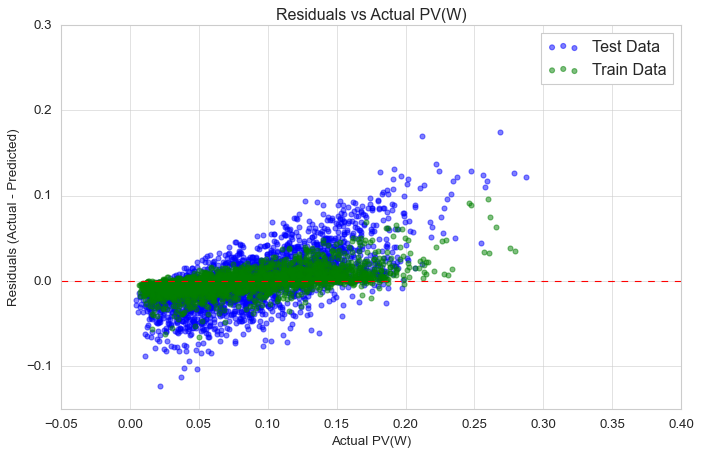

In [58]:
# plot residuals
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(y_train, y_train - y_train_pred, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Actual PV(W)')
plt.xlabel('Actual PV(W)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()


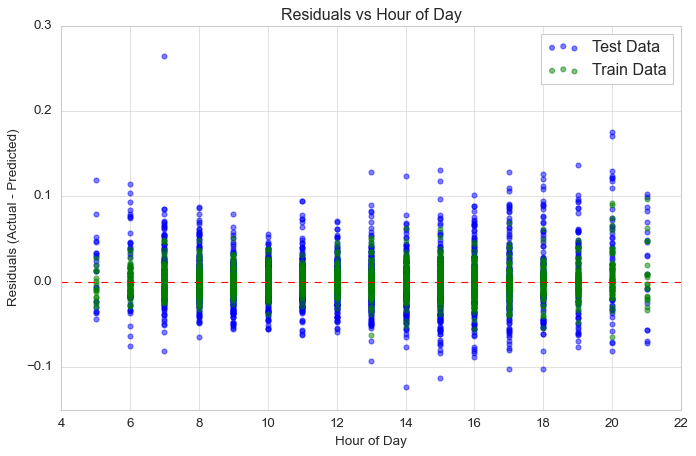

In [59]:
# plot risduals per hour of day
plt.figure(figsize=(10,6))
plt.scatter(df_daytime_test['DateTime'].dt.hour, y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(df_daytime_train['DateTime'].dt.hour, y_train - y_train_pred
, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

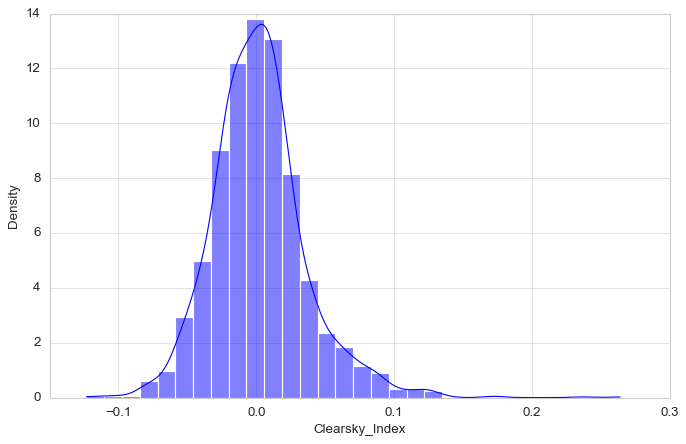

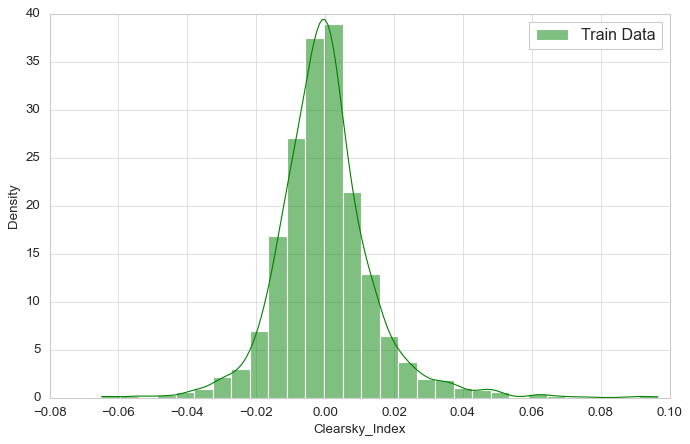

In [60]:
# Residual histogram
plt.figure(figsize=(10,6))
sns.histplot(y_test - y_test_pred, color='blue', label='Test Data', kde=True, stat="density", bins=30)
plt.figure(figsize=(10,6))
sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, stat="density", bins=30)
plt.legend()
plt.show()

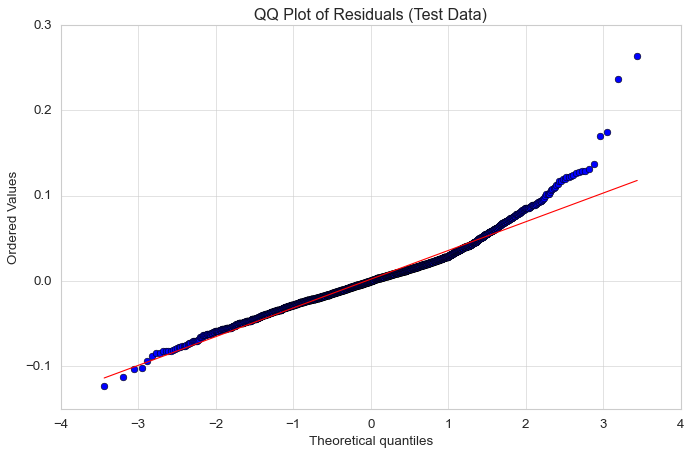

In [61]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()


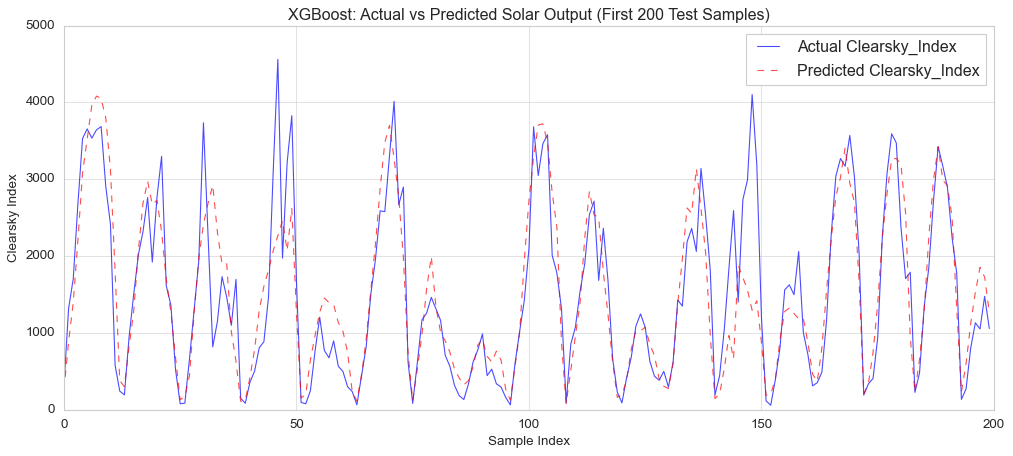

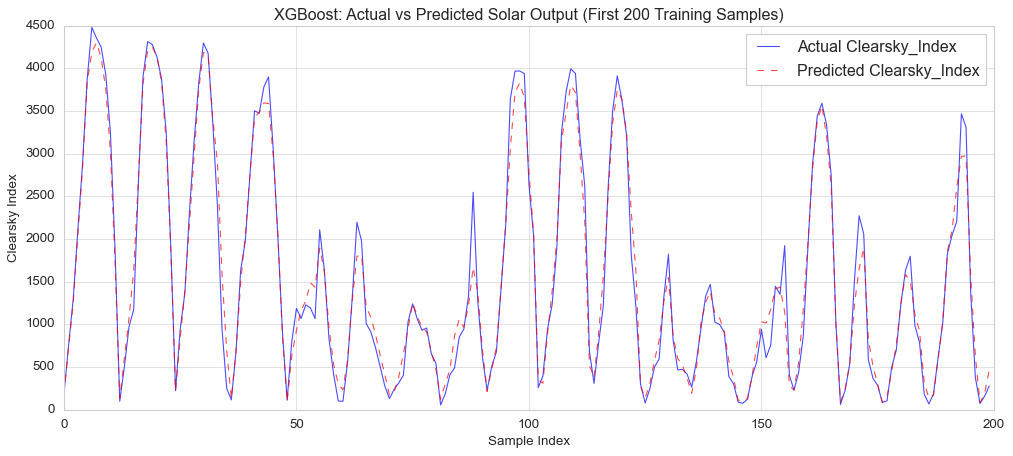

In [76]:
plt.figure(figsize=(15, 6))

plt.plot(y_test_pvw.values[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
plt.plot(y_test_pred_pvw[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Clearsky Index')
plt.legend()
plt.show()
plt.figure(figsize=(15, 6))

plt.plot(y_train_pvw.values[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
plt.plot(y_train_pred_pvw[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Clearsky Index')
plt.legend()
plt.show()

Write results to CSV file

In [63]:
with open(f'results/random_forest_regressor_hourly_test_metrics.csv', 'a') as f:
    # if this is first line write header
    if os.stat(f'results/random_forest_regressor_hourly_test_metrics.csv').st_size == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train Accuracy','Train N-RMSE %', 'Train N-MAE %', 
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\n')
    line=[]
    line.append("Random Forest Regressor Hourly")
    line.append(test_no)
    line.append(test_name)
    line.append(f"{target_col}")
    line.append(f"{test_rmse:.2f}")
    line.append(f"{test_mae:.2f}")
    line.append(f"{test_r2:.4f}")
    line.append(f"{test_n_rmse:.4f}")
    line.append(f"{test_n_mae:.4f}")
    line.append(f"{test_n_rmse*100:.4f}"  )
    line.append(f"{test_n_mae*100:.4f}"  )
    line.append(f"{test_accuracy:.4f}")
    line.append(f"{train_rmse:.2f}")
    line.append(f"{train_mae:.2f}")
    line.append(f"{train_r2:.4f}")
    line.append(f"{train_n_rmse:.4f}")
    line.append(f"{train_n_mae:.4f}")
    line.append(f"{train_n_rmse*100:.4f}"  )
    line.append(f"{train_n_mae*100:.4f}"  )
    line.append(f"{train_accuracy:.4f}")
    line.append(f"{notes if 'notes' in locals() else ''}")
    line.append(f"feature_cols: {':'.join(feature_cols)}")
    f.write(','.join(line) + '\n')